<a href="https://colab.research.google.com/github/kusumajangala/Personalised-product-recommendations-using-hybrid-filtering-and-sentiment-analysis/blob/main/flipkart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LOADING FLIPKART_MOBILE DATASET**






In [ ]:
import import_ipynb
import random
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/flipkart.csv', header=None) #There are no headers in the data file

df.columns = ['prod_id', 'price','descr','rating','user_id','review'] #Adding column names

df = df.drop('descr', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

In [ ]:
!pip install import-ipynb

In [ ]:
df.head()

,prod_id,price,rating,user_id,review
0,"OnePlus 11R 5G (Galactic Silver, 256 GB)","₹43,642",4.5,AKM1MP6P0OYPR,excellent product in perfect condition
1,"MOTOROLA Edge 30 Ultra (Interstellar Black, 25...","₹49,999",4.3,A2CX7LUOHB2NDG,good
2,"MOTOROLA Edge 30 Ultra (Starlight White, 256 GB)","₹49,999",4.3,A2NWSAGRHCP8N5,it is ok
3,"Google Pixel 7 (Snow, 128 GB)","₹49,999",4.3,A2WNBOD3WNDNKT,good
4,"Google Pixel 7 (Obsidian, 128 GB)","₹49,999",4.3,A1GI0U4ZRJA8WN,I like these phone I bought it for my mom and ...


In [ ]:
print("Total No of Ratings   :", df.shape[0])
print("Total No of Users     :", len(np.unique(df.user_id)))
print("Total No of Products  :", len(np.unique(df.prod_id)))

Total No of Ratings   : 666
Total No of Users     : 666
Total No of Products  : 483


In [ ]:
df.shape

(666, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   prod_id  666 non-null    object 
 1   price    666 non-null    object 
 2   rating   666 non-null    float64
 3   user_id  666 non-null    object 
 4   review   666 non-null    object 
dtypes: float64(1), object(4)
memory usage: 26.1+ KB


In [ ]:
df.describe()

,rating
count,666.000000
mean,4.152553
std,0.249392
min,3.300000
25%,4.000000
50%,4.200000
75%,4.300000
max,4.900000


**Exploratory Data Analysis**

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

In [ ]:
rating_counts = df['rating'].value_counts().sort_index()

# Create a bar plot using Plotly with the defined green color
fig = go.Figure(data=[go.Bar(x=rating_counts.index, y=rating_counts.values)])
fig.update_layout(title='Number of Ratings', xaxis_title='Rating', yaxis_title='Total Users', title_x=0.5)
fig.show()

In [ ]:
top_products = df['prod_id'].value_counts().head(5)

fig = go.Figure(data=[go.Bar(x=top_products.index, y=top_products.values, name='Top 5 Sold Products')])
fig.update_layout(title='Top 5 Sold Products', xaxis_title='Product', yaxis_title='Number of Purchases',
                  title_x=0.5)
fig.show()

In [ ]:
user_id_to_recommend = str(input("Enter the user ID to retrieve interactions: "))

# Get the user's interactions (Item_id, title, category, and brand)
user_interactions = df[df['user_id'] == user_id_to_recommend][['prod_id', 'price','rating','review']]\
    .drop_duplicates('prod_id')
print(f"User {user_id_to_recommend} Interacted for the following products:")
user_interactions

Enter the user ID to retrieve interactions: A2AEHUKOV014BP
User A2AEHUKOV014BP Interacted for the following products:


,prod_id,price,rating,review
22,"realme GT 2 Pro (Paper White, 128 GB)","₹49,999",4.2,Excelente


*****Content-Based Recommender*****

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

class ContentBasedRecommender:
    def __init__(self, df):
        self.df = df
        self.category_similar_matrix = self._get_similarity_matrix(self.df['price'])
        self.brand_similar_matrix = self._get_similarity_matrix(self.df['review'])

    def _get_similarity_matrix(self, attribute_data):
        # Create a DataFrame with item_id and attribute_data
        df_attribute = pd.DataFrame({'prod_id': self.df['prod_id'], 'attribute_data': attribute_data})

        # Drop duplicate entries based on item_id, keeping only the first occurrence
        df_attribute_unique = df_attribute.drop_duplicates(subset='prod_id', keep='first')

        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        doc_term = tfidf_vectorizer.fit_transform(df_attribute_unique['attribute_data'])
        dt_matrix = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in df_attribute_unique['prod_id']],
                                 columns=tfidf_vectorizer.get_feature_names_out())
        cos_similar_matrix = pd.DataFrame(cosine_similarity(dt_matrix.values), columns=df_attribute_unique['prod_id'],
                                          index=df_attribute_unique['prod_id'])
        return cos_similar_matrix

    def get_recommendations(self, user_id, top_n=5):
        # Create an empty list to store recommendations
        top_n_recommendations = []

        # Get the user's item interactions from the dataset
        user_items = self.df[self.df['user_id'] == user_id]['prod_id']

        # Combine category and brand similarity (e.g., by taking the average)
        combined_similar_matrix = (self.category_similar_matrix + self.brand_similar_matrix) / 2

        # Iterate through the user's interactions
        for item_id in user_items:
            # Get similar items based on the combined similarity matrix for the current item
            similar_items = combined_similar_matrix.loc[item_id]
            similar_items = similar_items.sort_values(ascending=False)

            # Exclude items that the user has already interacted with
            similar_items = similar_items[~similar_items.index.isin(user_items)]

            # Get top-N recommended items for the user from the current item's similarity
            top_n_items = similar_items.head(top_n).index.tolist()
            top_n_recommendations.extend(top_n_items)

        # Return the list of top-N recommendations for the user (excluding their own interactions)
        return list(set(top_n_recommendations) - set(user_items))

In [ ]:
content_recommender = ContentBasedRecommender(df)
top_n_recommendations_content_based = content_recommender.get_recommendations(user_id_to_recommend)

# Get the model's recommended products (Item_id, title, category, and brand)
recommendations = df[df['prod_id'].isin(top_n_recommendations_content_based)][
    ['prod_id', 'price', 'rating', 'review']].drop_duplicates('prod_id')
print(f"Model recommends the following products to the user {user_id_to_recommend}:")
recommendations

Model recommends the following products to the user A2AEHUKOV014BP:


,prod_id,price,rating,review
1,"MOTOROLA Edge 30 Ultra (Interstellar Black, 25...","₹49,999",4.3,good
20,"OnePlus 10T 5G (Jade Green, 256 GB)","₹48,990",4.2,Excelente
109,"OnePlus 10 Pro 5G (Emerald Forest, 128 GB)","₹49,999",4.2,good quality phone
110,"OnePlus 9RT 5G (Hacker Black, 256 GB)","₹49,999",4.3,does not work well with T-Mobile. T-Mobile clo...
148,"OnePlus 9 5G (Arctic Sky, 256 GB)","₹39,999",4.0,Excelente


**Collaborative Filtering Recommender**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity

class CollaborativeFilteringRecommender:
    def __init__(self, df):
        self.df = df
        # Create user-item interaction matrix
        self.user_item_matrix = self.df.pivot_table(index='user_id', columns='prod_id', values='rating').fillna(0)
        self.user_similarity_matrix = self._get_user_similarity_matrix()

    def _get_user_similarity_matrix(self):
        # Create user similarity matrix using cosine similarity
        user_similarity_matrix = pd.DataFrame(cosine_similarity(self.user_item_matrix),
                                              index=self.user_item_matrix.index,
                                              columns=self.user_item_matrix.index)
        return user_similarity_matrix

    def get_recommendations(self, user_id, top_n=10):
        # Get the similarity scores between the target user and all other users
        user_similarity = self.user_similarity_matrix[user_id]

        # Get the indices of the top N similar users (excluding the target user itself)
        similar_user_indices = user_similarity.argsort()[::-1][1:top_n + 1]

        # Get the products that the similar users have interacted with
        recommended_products = set()
        for index in similar_user_indices:
            similar_user_id = self.df.iloc[index]['user_id']
            products_interacted = self.df[self.df['user_id'] == similar_user_id]['prod_id'].tolist()
            recommended_products.update(products_interacted)

        # Remove the products that the target user has already interacted with
        target_user_products = self.df[self.df['user_id'] == user_id]['prod_id']
        recommended_products = recommended_products - set(target_user_products)

        # Return the top N recommended products
        top_n_items = self.df[self.df['prod_id'].isin(recommended_products)]['prod_id'].head(top_n)
        return top_n_items

In [ ]:
collab_filter_recommender = CollaborativeFilteringRecommender(df)
top_n_recommendations_collab_filtering = collab_filter_recommender.get_recommendations(user_id_to_recommend)

# Get the model's recommended products (Item_id, title, category, and brand)
recommendations = df[df['prod_id'].isin(top_n_recommendations_collab_filtering)][
    ['prod_id', 'price', 'rating', 'review']].drop_duplicates('prod_id')
print(f"Model recommends the following products to the user {user_id_to_recommend}:")
recommendations

Model recommends the following products to the user A2AEHUKOV014BP:


,prod_id,price,rating,review
218,"Infinix HOT 30i (Mirror Black, 64 GB)","₹8,199",4.3,It's a good phone for emergencies and the numb...
219,"Infinix HOT 30i (Glacier Blue, 128 GB)","₹9,039",4.3,but did not work with Iwirless
220,"POCO C55 (Forest Green, 64 GB)","₹7,499",4.2,Does not have Cyrillic! That was a surprize
221,"POCO C50 (Country Green, 32 GB)","₹5,499",4.2,We bought the phone for my 92 year old mother ...
222,Nokia 105,"₹1,299",4.0,As arrival of this phone and I couldn't charge...
224,"POCO M5 (Icy Blue, 64 GB)","₹8,499",4.1,My Dad loves it - works great with no confusin...
225,"MOTOROLA e13 (Creamy White, 64 GB)","₹7,299",4.0,Very bad same week i bought could not turn on ...
226,"MOTOROLA e32 (Eco Black, 64 GB)","₹7,999",3.9,Both of my grandmas love it!!! It could have a...


**Hybrid Recommender**


In [ ]:
class HybridRecommender:
    def __init__(self, df, content_based_weight=0.5, collaborative_filtering_weight=0.5):
        self.content_based_recommender = ContentBasedRecommender(df)
        self.collaborative_filtering_recommender = CollaborativeFilteringRecommender(df)
        self.content_based_weight = content_based_weight
        self.collaborative_filtering_weight = collaborative_filtering_weight

    def get_recommendations(self, user_id, top_n=10):
        # Get recommendations from both content-based and collaborative filtering recommenders
        content_based_recommendations = self.content_based_recommender.get_recommendations(user_id, top_n)
        collaborative_filtering_recommendations = self.collaborative_filtering_recommender.get_recommendations(user_id,
                                                                                                               top_n)

        # Combine the recommendations using weighted average
        hybrid_recommendations = {}
        for item in content_based_recommendations:
            hybrid_recommendations[item] = hybrid_recommendations.get(item, 0) + self.content_based_weight
        for item in collaborative_filtering_recommendations:
            hybrid_recommendations[item] = hybrid_recommendations.get(item, 0) + self.collaborative_filtering_weight

        # Sort the hybrid recommendations based on the weighted score and select the top N items
        hybrid_recommendations = sorted(hybrid_recommendations.items(), key=lambda x: x[1], reverse=True)
        hybrid_recommendations = [item for item, score in hybrid_recommendations[:top_n]]

        return hybrid_recommendations

In [ ]:
hybrid_recommender = HybridRecommender(df, content_based_weight=0.4, collaborative_filtering_weight=0.6)
top_n_recommendations_hybrid = hybrid_recommender.get_recommendations(user_id_to_recommend)

# Get the model's recommended products
recommendations = df[df['prod_id'].isin(top_n_recommendations_hybrid)][
    ['prod_id', 'price', 'rating', 'review']].drop_duplicates('prod_id')
print(f"Model recommends the following products to the user {user_id_to_recommend}:")
recommendations

Model recommends the following products to the user A2AEHUKOV014BP:


,prod_id,price,rating,review
37,"realme GT 2 Pro (Steel Black, 128 GB)","₹49,999",4.2,"The keys are a little hard to hit, and I didn'..."
109,"OnePlus 10 Pro 5G (Emerald Forest, 128 GB)","₹49,999",4.2,good quality phone
218,"Infinix HOT 30i (Mirror Black, 64 GB)","₹8,199",4.3,It's a good phone for emergencies and the numb...
219,"Infinix HOT 30i (Glacier Blue, 128 GB)","₹9,039",4.3,but did not work with Iwirless
220,"POCO C55 (Forest Green, 64 GB)","₹7,499",4.2,Does not have Cyrillic! That was a surprize
221,"POCO C50 (Country Green, 32 GB)","₹5,499",4.2,We bought the phone for my 92 year old mother ...
222,Nokia 105,"₹1,299",4.0,As arrival of this phone and I couldn't charge...
224,"POCO M5 (Icy Blue, 64 GB)","₹8,499",4.1,My Dad loves it - works great with no confusin...
225,"MOTOROLA e13 (Creamy White, 64 GB)","₹7,299",4.0,Very bad same week i bought could not turn on ...
226,"MOTOROLA e32 (Eco Black, 64 GB)","₹7,999",3.9,Both of my grandmas love it!!! It could have a...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Evaluation of the models**

In [ ]:
def compute_coverage(recommendations, item_catalog):
    recommended_items = set(item for user_rec in recommendations.values() for item in user_rec)
    coverage = len(recommended_items) / len(item_catalog)
    return coverage

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def compute_diversity(recommendations):
    user_item_sets = {user: set(items) for user, items in recommendations.items()}
    diversity_sum = 0
    total_users = len(user_item_sets)

    for user1, items1 in user_item_sets.items():
        for user2, items2 in user_item_sets.items():
            if user1 != user2:
                diversity_sum += jaccard_similarity(items1, items2)

    diversity = diversity_sum / (total_users * (total_users - 1))
    return diversity

def compute_novelty(recommendations, item_popularity):
    total_novelty = 0
    num_users = len(recommendations)

    # Calculate the maximum possible novelty value
    max_novelty = sum(item_popularity.values())

    for user_rec in recommendations.values():
        novelty_sum = sum(item_popularity[item] for item in user_rec)
        total_novelty += novelty_sum / len(user_rec)

    # Normalize the calculated novelty values
    novelty = total_novelty / (num_users * max_novelty)
    scaled_novelty = novelty * 100  # Scale novelty to percentage
    return scaled_novelty

In [ ]:
# Function to randomly sample subsets of users from the dataset
def random_sample(df, subset_size=100, num_subsets=50):
    user_ids = df['user_id'].unique().tolist()
    random_samples = []
    for i in range(num_subsets):
        random_subset = random.sample(user_ids, subset_size)
        random_samples.append(random_subset)
    return random_samples

# Randomly sample subsets of users
subset_size = 100
num_subsets = 100
random_samples = random_sample(df, subset_size, num_subsets)

# Dictionary to store the evaluation results for each subset
evaluation_results = {
    'coverage_collab': [],
    'coverage_content': [],
    'coverage_hybrid': [],
    'diversity_collab': [],
    'diversity_content': [],
    'diversity_hybrid': [],
    'novelty_collab': [],
    'novelty_content': [],
    'novelty_hybrid': []
}
item_catalog = list(df['prod_id'].unique())
item_popularity = df['prod_id'].value_counts().to_dict()

for subset in random_samples:
    # Filter the data based on the user IDs in the subset
    subset_data = df[df['user_id'].isin(subset)]

    # Create the model instance with the filtered subset data
    collab_filtering_recommender = CollaborativeFilteringRecommender(subset_data)
    content_based_recommender = ContentBasedRecommender(subset_data)
    hybrid_recommender = HybridRecommender(subset_data)

    user_recommendations_collab = {}
    user_recommendations_content = {}
    user_recommendations_hybrid = {}

    for user_id in subset:
        user_recommendations_collab[user_id] = collab_filtering_recommender.get_recommendations(user_id, top_n=10)
        user_recommendations_content[user_id] = content_based_recommender.get_recommendations(user_id, top_n=10)
        user_recommendations_hybrid[user_id] = hybrid_recommender.get_recommendations(user_id, top_n=10)

    coverage_collab = compute_coverage(user_recommendations_collab, item_catalog)
    coverage_content = compute_coverage(user_recommendations_content, item_catalog)
    coverage_hybrid = compute_coverage(user_recommendations_hybrid, item_catalog)
    diversity_collab = compute_diversity(user_recommendations_collab)
    diversity_content = compute_diversity(user_recommendations_content)
    diversity_hybrid = compute_diversity(user_recommendations_hybrid)

    novelty_collab = compute_novelty(user_recommendations_collab, item_popularity)
    novelty_content = compute_novelty(user_recommendations_content, item_popularity)
    novelty_hybrid = compute_novelty(user_recommendations_hybrid, item_popularity)

    evaluation_results['coverage_collab'].append(coverage_collab)
    evaluation_results['coverage_content'].append(coverage_content)
    evaluation_results['coverage_hybrid'].append(coverage_hybrid)
    evaluation_results['diversity_collab'].append(diversity_collab)
    evaluation_results['diversity_content'].append(diversity_content)
    evaluation_results['diversity_hybrid'].append(diversity_hybrid)
    evaluation_results['novelty_collab'].append(novelty_collab)
    evaluation_results['novelty_content'].append(novelty_content)
    evaluation_results['novelty_hybrid'].append(novelty_hybrid)

In [ ]:
average_novelty = {
    'collaborative': sum(evaluation_results['novelty_collab']) / len(evaluation_results['novelty_collab']),
    'content-based': sum(evaluation_results['novelty_content']) / len(evaluation_results['novelty_content']),
    'hybrid': sum(evaluation_results['novelty_hybrid']) / len(evaluation_results['novelty_hybrid'])
}

average_coverage = {
    'collaborative': sum(evaluation_results['coverage_collab']) / len(evaluation_results['coverage_collab']),
    'content-based': sum(evaluation_results['coverage_content']) / len(evaluation_results['coverage_content']),
    'hybrid': sum(evaluation_results['coverage_hybrid']) / len(evaluation_results['coverage_hybrid'])
}

average_diversity = {
    'collaborative': sum(evaluation_results['diversity_collab']) / len(evaluation_results['diversity_collab']),
    'content-based': sum(evaluation_results['diversity_content']) / len(evaluation_results['diversity_content']),
    'hybrid': sum(evaluation_results['diversity_hybrid']) / len(evaluation_results['diversity_hybrid'])
}

print("Average Novelty:")
print(average_novelty)

print("\nAverage Coverage:")
print(average_coverage)

print("\nAverage Diversity:")
print(average_diversity)

Average Novelty:
{'collaborative': 0.20673273273273277, 'content-based': 0.24253153153153179, 'hybrid': 0.2453153153153154}

Average Coverage:
{'collaborative': 0.03867494824016565, 'content-based': 0.1915320910973086, 'hybrid': 0.1907453416149069}

Average Diversity:
{'collaborative': 0.753434479325451, 'content-based': 0.13919071272411176, 'hybrid': 0.14706040736390555}


In [ ]:
fig_coverage = go.Figure()

# Plot the evaluation results for Coverage of each model
fig_coverage.add_trace(go.Box(y=evaluation_results['coverage_content'], name='Content-Based',
                              boxpoints='all', jitter=0.4))
fig_coverage.add_trace(go.Box(y=evaluation_results['coverage_collab'], name='Collaborative Filtering',
                              boxpoints='all', jitter=0.4))
fig_coverage.add_trace(go.Box(y=evaluation_results['coverage_hybrid'], name='Hybrid Model',
                              boxpoints='all', jitter=0.4))

# Update the layout of the figure
fig_coverage.update_layout(title='Model Performance for Coverage',
                           xaxis_title='Model', title_x = 0.5,
                           yaxis_title='Metric Value',
                           showlegend=False)

# Show the figure
fig_coverage.show()

In [ ]:
fig_diversity = go.Figure()

# Plot the evaluation results for Diversity of each model
fig_diversity.add_trace(go.Box(y=evaluation_results['diversity_content'], name='Content-Based',
                               boxpoints='all', jitter=0.4))
fig_diversity.add_trace(go.Box(y=evaluation_results['diversity_collab'], name='Collaborative Filtering',
                               boxpoints='all', jitter=0.4))
fig_diversity.add_trace(go.Box(y=evaluation_results['diversity_hybrid'], name='Hybrid Model',
                               boxpoints='all', jitter=0.4))

# Update the layout of the figure
fig_diversity.update_layout(title='Model Performance for Diversity',
                            xaxis_title='Model', title_x = 0.5,
                            yaxis_title='Metric Value',
                            showlegend=False)

# Show the figure
fig_diversity.show()

In [ ]:
fig_novelty = go.Figure()

# Plot the evaluation results for Novelty of each model
fig_novelty.add_trace(go.Box(y=evaluation_results['novelty_content'], name='Content-Based',
                             boxpoints='all', jitter=0.4))
fig_novelty.add_trace(go.Box(y=evaluation_results['novelty_collab'], name='Collaborative Filtering',
                             boxpoints='all', jitter=0.4))
fig_novelty.add_trace(go.Box(y=evaluation_results['novelty_hybrid'], name='Hybrid Model',
                             boxpoints='all', jitter=0.4))

# Update the layout of the figure
fig_novelty.update_layout(title='Model Performance for Novelty',
                  xaxis_title='Model', title_x = 0.5,
                  yaxis_title='Metric Value',
                  showlegend=False)

# Show the figure
fig_novelty.show()


**Recommendation**

In [ ]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import display


In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/flipkart 2.csv',\
                      encoding='latin-1')
# ratings.reset_index(drop=True, inplace=True)

ratings.columns = ['prod_name', 'price', 'desc', 'rating','user_id','review'] #Adding column names

df_copy = ratings.copy(deep=True) #Copying the data to another dataframe
display(ratings.sample(n=5, random_state=42))

,prod_name,price,desc,rating,user_id,review
281,Micromax X512,"â¹1,099",32 MB RAM | 32 MB ROM4.5 cm (1.77 inch) Displa...,3.9,A2BWX768VJ5QFS,This is my second sim card I have to use to ac...
286,"Google Pixel 6a (Chalk, 128 GB)","â¹26,999",6 GB RAM | 128 GB ROM15.6 cm (6.14 inch) Full ...,4.3,A28YQET4K11XVA,Lots of nice features but touch response slow....
473,Motorola a70,"â¹1,869",4 MB RAM | 4 MB ROM | Expandable Upto 32 GB6.1...,4.0,A1YQJNKIMRBU1M,I read the reviews which after the fact I am g...
227,"MOTOROLA G62 5G (Midnight Gray, 128 GB)","â¹15,999",8 GB RAM | 128 GB ROM41.94 cm (16.51 cm) Full ...,4.1,A3A5LQ5T7M7I8V,Pros:* The cradle is nice* Lack of camera* Che...
436,"realme 11 Pro+ 5G (Oasis Green, 256 GB)","â¹27,999",8 GB RAM | 256 GB ROM17.02 cm (6.7 inch) Full ...,4.3,A1M7VPG9Q6JEO8,love it


In [ ]:
def apply_pivot(df,fillby = None):
    if fillby is not None:
        return df.pivot_table(index='user_id', columns='prod_name',values='rating').fillna(fillby)
    return df.pivot_table(index='user_id', columns='prod_name',values='rating')


#3.1 Dividing the dataset into train and test
train, test = train_test_split(ratings, test_size=0.30, random_state=42)
test = test[test.user_id.isin(train.user_id)]
#3.2 Apply pivot operation and fillna used to replace NaN values with 0 i.e. where user didn't made any rating
df_train_pivot = apply_pivot(df = train, fillby = 0)
df_test_pivot = apply_pivot(df = test, fillby = 0)
#3.3 dummy dataset (train and test)
## Train
dummy_train = train.copy()
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)
dummy_train = apply_pivot(df = dummy_train, fillby = 1)
## Test
dummy_test = test.copy()
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = apply_pivot(df = dummy_test, fillby = 0)

In [ ]:
mean = np.nanmean(apply_pivot(df = train), axis = 1)
df_train_subtracted = (apply_pivot(df = train).T-mean).T
# Make rating=0 where user hasn't given any rating
df_train_subtracted.fillna(0, inplace = True)
# Creating the User Similarity Matrix using pairwise_distance function. shape of user_correlation is userXuser i.e. 2071X2071
user_correlation = 1 - pairwise_distances(df_train_subtracted, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
# user_correlation[user_correlation<0] = 0
# Convert the user_correlation matrix into dataframe
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df['user_d'] = df_train_subtracted.index
user_correlation_df.set_index('user_d',inplace=True)
user_correlation_df.columns = df_train_subtracted.index.tolist()

In [ ]:
user_predicted_ratings = np.dot(user_correlation, df_train_pivot)

# To find only product not rated by the user, ignore the product rated by the user by making it zero.
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)


In [ ]:
import pandas as pd

def find_top_recommendations(pred_rating_df, userid, topn):
    # Make a copy of the DataFrame to avoid modifying the original
    pred_df_copy = pred_rating_df.copy()

    # Exclude the user's own ratings from the recommendations
    pred_df_copy.loc[userid, :] = 0

    # Sort values in descending order and get the top recommendations
    recommendation = pred_df_copy.loc[userid].sort_values(ascending=False)[0:topn]

    # Create a DataFrame from the recommendations
    recommendation_df = pd.DataFrame(recommendation).reset_index().rename(columns={userid: 'predicted_ratings'})

    return recommendation_df

# Assuming you have a DataFrame named user_final_rating and another named train

# Get user input
user_input = input("Enter your user id: ")

# Call the recommendation function
recommendation_user_user = find_top_recommendations(user_final_rating, user_input, 5)
recommendation_user_user['user_id'] = user_input

# Print recommended products in descending order
print("Recommended products for user id: {} in descending order as below".format(user_input))
print(recommendation_user_user.sort_values('predicted_ratings', ascending=False))

# Print earlier rated products by the user
print("Earlier rated products by user id: {} as below".format(user_input))
print(train[train['user_id'] == user_input].sort_values(['rating'], ascending=True))


Enter your user id: A2AEHUKOV014BP
Recommended products for user id: A2AEHUKOV014BP in descending order as below
                                        prod_name  predicted_ratings  \
0                                            A10E                0.0   
1       REDMI Note 12 Pro 5G (Onyx Black, 128 GB)                0.0   
2  SAMSUNG Galaxy A52s 5G (Awesome Black, 128 GB)                0.0   
3                            SAMSUNG GURU MUSIC 2                0.0   
4       SAMSUNG GALAXY M13 5G (Aqua Green, 64 GB)                0.0   

          user_id  
0  A2AEHUKOV014BP  
1  A2AEHUKOV014BP  
2  A2AEHUKOV014BP  
3  A2AEHUKOV014BP  
4  A2AEHUKOV014BP  
Earlier rated products by user id: A2AEHUKOV014BP as below
                                prod_name      price  \
28      Mi 10T Pro (Cosmic Black, 128 GB)  â¹47,999   
20  realme GT 2 Pro (Paper White, 128 GB)  â¹49,999   
48  Nothing Phone (2) (Dark Grey, 128 GB)  â¹44,999   
47        APPLE iPhone 11 (White, 128 GB)  â¹44,99

In [ ]:
import pandas as pd

def find_top_recommendations(pred_rating_df, userid, topn):
    # Make a copy of the DataFrame to avoid modifying the original
    pred_df_copy = pred_rating_df.copy()

    # Exclude the user's own ratings from the recommendations
    pred_df_copy.loc[userid, :] = 0

    # Sort values in descending order and get the top recommendations
    recommendation = pred_df_copy.loc[userid].sort_values(ascending=True)[0:topn]

    # Create a DataFrame from the recommendations
    recommendation_df = pd.DataFrame(recommendation).reset_index().rename(columns={userid: 'predicted_ratings'})

    return recommendation_df

# Assuming you have a DataFrame named user_final_rating and another named train

# Get user input
user_input = input("Enter your user id: ")

# Call the recommendation function
recommendation_user_user = find_top_recommendations(user_final_rating, user_input, 5)
recommendation_user_user['user_id'] = user_input

# Print recommended products in descending order
print("Recommended products for user id: {} in descending order as below".format(user_input))
print(recommendation_user_user.sort_values('predicted_ratings', ascending=False))

# Print earlier rated products by the user
print("Earlier rated products by user id: {} as below".format(user_input))
print(train[train['user_id'] == user_input].sort_values(['rating'], ascending=True))



Enter your user id: A2WOJCFAWI8VS8
Recommended products for user id: A2WOJCFAWI8VS8 in descending order as below
                                   prod_name  predicted_ratings  \
0                                       A10E                0.0   
1                       SAMSUNG GURU MUSIC 2                0.0   
2  SAMSUNG GALAXY M13 5G (Aqua Green, 64 GB)                0.0   
3    SAMSUNG A52s 5G (Awesome Black, 128 GB)                0.0   
4               SAMSUNG A52s (Black, 128 GB)                0.0   

          user_id  
0  A2WOJCFAWI8VS8  
1  A2WOJCFAWI8VS8  
2  A2WOJCFAWI8VS8  
3  A2WOJCFAWI8VS8  
4  A2WOJCFAWI8VS8  
Earlier rated products by user id: A2WOJCFAWI8VS8 as below
                              prod_name      price  \
37  realme X50 Pro (Moss Green, 256 GB)  â¹47,999   

                                                 desc  rating         user_id  \
37  12 GB RAM | 256 GB ROM16.36 cm (6.44 inch) Ful...     4.4  A2WOJCFAWI8VS8   

                                 

In [ ]:
pip install tabulate


In [ ]:
import pandas as pd

def find_top_recommendations(pred_rating_df, userid, topn):
    # Make a copy of the DataFrame to avoid modifying the original
    pred_df_copy = pred_rating_df.copy()

    # Exclude the user's own ratings from the recommendations
    pred_df_copy.loc[userid, :] = 0

    # Sort values in descending order and get the top recommendations
    recommendation = pred_df_copy.loc[userid].sort_values(ascending=True)[0:topn]

    # Create a DataFrame from the recommendations
    recommendation_df = pd.DataFrame(recommendation).reset_index().rename(columns={userid: 'predicted_ratings'})

    return recommendation_df

# Assuming you have a DataFrame named user_final_rating and another named train

# Get user input
user_input = input("Enter your user id: ")

# Call the recommendation function
recommendation_user_user = find_top_recommendations(user_final_rating, user_input, 5)
recommendation_user_user['user_id'] = user_input

# Print recommended products in descending order
print("Recommended products for user id: {} in descending order as below".format(user_input))
print(recommendation_user_user.sort_values('predicted_ratings', ascending=False))

# Print earlier rated products by the user
print("Earlier rated products by user id: {} as below".format(user_input))
print(train[train['user_id'] == user_input].sort_values(['rating'], ascending=True))

Enter your user id: A1E4WG8HRWWK4R
Recommended products for user id: A1E4WG8HRWWK4R in descending order as below
                                   prod_name  predicted_ratings  \
0                                       A10E                0.0   
1                       SAMSUNG GURU MUSIC 2                0.0   
2  SAMSUNG GALAXY M13 5G (Aqua Green, 64 GB)                0.0   
3    SAMSUNG A52s 5G (Awesome Black, 128 GB)                0.0   
4               SAMSUNG A52s (Black, 128 GB)                0.0   

          user_id  
0  A1E4WG8HRWWK4R  
1  A1E4WG8HRWWK4R  
2  A1E4WG8HRWWK4R  
3  A1E4WG8HRWWK4R  
4  A1E4WG8HRWWK4R  
Earlier rated products by user id: A1E4WG8HRWWK4R as below
                      prod_name      price  \
27  IQOO 9T 5G (LEGEND, 128 GB)  â¹49,499   

                                                 desc  rating         user_id  \
27  8 GB RAM | 128 GB ROM17.22 cm (6.78 inch) Disp...     4.1  A1E4WG8HRWWK4R   

                                               re

In [ ]:
user_correlation_test_df = user_correlation_df[user_correlation_df.index.isin(test.user_id)]
user_correlation_test_df = user_correlation_test_df[list(set(test.user_id))]
# user_correlation_test_df[user_correlation_test_df<0]=0

#Get test user predicted rating
test_user_predicted_ratings = np.dot(user_correlation_test_df, df_test_pivot)
test_user_predicted_ratings = np.multiply(test_user_predicted_ratings,dummy_test)
#Get NaN where user never rated as it shouldn't contribute in calculating RMSE
test_user_predicted_ratings = test_user_predicted_ratings[test_user_predicted_ratings>0]
scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(test_user_predicted_ratings)
test_user_predicted_ratings = scaler.transform(test_user_predicted_ratings)

total_non_nan = np.count_nonzero(~np.isnan(test_user_predicted_ratings))
rmse = (np.sum(np.sum((apply_pivot(df = test) - test_user_predicted_ratings)**2))/total_non_nan)**0.5
print(rmse)

3.5999999999999996


In [ ]:
import os

# Specify the directory path you want to create
directory_path = './model'

# Use os.makedirs to create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

In [ ]:
import os
import pickle

# Specify the directory path
directory_path = './model'

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Assuming user_final_rating is defined and contains the data you want to save

# Save user_final_rating using pickle
with open(os.path.join(directory_path, 'user_final_rating.pkl'), 'wb') as file:
    pickle.dump(user_final_rating, file)


In [ ]:
pickle.dump(user_final_rating,open('./model/user_final_rating.pkl','wb'))

**Sentiment**

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn import over_sampling
from IPython.display import display

# Reading product review sentiment file
df_prod_review = pd.read_csv('/content/drive/MyDrive/flipkart 2.csv',\
                      encoding='latin-1')

df_prod_review.columns = ['prod_name', 'price', 'desc', 'rating','user_id','review'] #Adding column names

df_copy = df_prod_review.copy(deep=True) #Copying the data to another dataframe
display(df_prod_review.sample(n=5, random_state=42))

,prod_name,price,desc,rating,user_id,review
281,Micromax X512,"â¹1,099",32 MB RAM | 32 MB ROM4.5 cm (1.77 inch) Displa...,3.9,A2BWX768VJ5QFS,This is my second sim card I have to use to ac...
286,"Google Pixel 6a (Chalk, 128 GB)","â¹26,999",6 GB RAM | 128 GB ROM15.6 cm (6.14 inch) Full ...,4.3,A28YQET4K11XVA,Lots of nice features but touch response slow....
473,Motorola a70,"â¹1,869",4 MB RAM | 4 MB ROM | Expandable Upto 32 GB6.1...,4.0,A1YQJNKIMRBU1M,I read the reviews which after the fact I am g...
227,"MOTOROLA G62 5G (Midnight Gray, 128 GB)","â¹15,999",8 GB RAM | 128 GB ROM41.94 cm (16.51 cm) Full ...,4.1,A3A5LQ5T7M7I8V,Pros:* The cradle is nice* Lack of camera* Che...
436,"realme 11 Pro+ 5G (Oasis Green, 256 GB)","â¹27,999",8 GB RAM | 256 GB ROM17.02 cm (6.7 inch) Full ...,4.3,A1M7VPG9Q6JEO8,love it


In [ ]:
x=df_prod_review['review']
y=df_prod_review['rating']
print("Checking distribution of +ve and -ve review sentiment: \n{}".format(y.value_counts(normalize=True)))
# Split the dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)

Checking distribution of +ve and -ve review sentiment: 
4.2    0.216867
4.3    0.191265
4.1    0.165663
4.0    0.112952
4.4    0.094880
3.9    0.060241
3.8    0.034639
4.6    0.031627
4.5    0.027108
3.5    0.024096
3.3    0.015060
3.6    0.010542
4.7    0.006024
3.4    0.004518
4.9    0.003012
3.7    0.001506
Name: rating, dtype: float64


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn import over_sampling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Assuming df_prod_review is your DataFrame containing 'review' and 'rating' columns

# Convert ratings to binary labels (positive/negative)
df_prod_review['sentiment'] = df_prod_review['rating'].apply(lambda rating: 1 if rating >= 4 else 0)

# Split the dataset into test and train
x = df_prod_review['review']
y = df_prod_review['sentiment']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)

# Perform oversampling using RandomOverSampler
ros = over_sampling.RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(pd.DataFrame(X_train), pd.Series(y_train))

# Convert X_train_resampled back to list of strings
X_train_resampled = X_train_resampled['review'].tolist()

# Example: Using a simple Naive Bayes classifier for sentiment analysis
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_resampled)
X_test_vectorized = vectorizer.transform(X_test)

# Create and train the classifier
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train_resampled)

# Make predictions
y_pred = classifier.predict(X_test_vectorized)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.19      0.31      0.24        32
           1       0.85      0.74      0.79       168

    accuracy                           0.68       200
   macro avg       0.52      0.53      0.51       200
weighted avg       0.74      0.68      0.70       200



In [ ]:
word_vectorizer = TfidfVectorizer(strip_accents='unicode', token_pattern=r'\w{1,}',\
                                ngram_range=(1, 3), stop_words='english', sublinear_tf=True)

# Fiting it on Train
word_vectorizer.fit(X_train)
# transforming the train and test datasets
X_train_transformed = word_vectorizer.transform(X_train)
X_test_transformed = word_vectorizer.transform(X_test.tolist())

In [ ]:
def evaluate_model(y_pred,y_actual):
    print(classification_report(y_true = y_actual, y_pred = y_pred))
    #confusion matrix
    cm = confusion_matrix(y_true = y_actual, y_pred = y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    #Calculating the Sensitivity
    sensitivity = round(TP/float(FN + TP),2)
    print("sensitivity: {}".format(sensitivity))
    #Calculating the Specificity
    specificity = round(TN / float(TN + FP),2)
    print("specificity: {}".format(specificity))

#4.1 Model Training
logit = LogisticRegression()
logit.fit(X_train_transformed,y_train)
#4.2 Prediction on Train Data
y_pred_train= logit.predict(X_train_transformed)
#4.3 Prediction on Test Data
y_pred_test = logit.predict(X_test_transformed)
#4.4 Evaluation on Train
print("Evaluation on Train dataset ..")
evaluate_model(y_pred = y_pred_train, y_actual = y_train)
print("Evaluation on Test dataset ..")
#4.5 Evaluation on Test
evaluate_model(y_pred = y_pred_test, y_actual = y_test)

Evaluation on Train dataset ..
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.85      1.00      0.92       396

    accuracy                           0.85       464
   macro avg       0.43      0.50      0.46       464
weighted avg       0.73      0.85      0.79       464

sensitivity: 1.0
specificity: 0.0
Evaluation on Test dataset ..
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.84      1.00      0.91       168

    accuracy                           0.84       200
   macro avg       0.42      0.50      0.46       200
weighted avg       0.71      0.84      0.77       200

sensitivity: 1.0
specificity: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

In [ ]:
import os
import pickle

# Specify the directory path
directory_path = './model'

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Assuming user_final_rating is defined and contains the data you want to save

# Save user_final_rating using pickle
pickle.dump(logit,open('./model/logit_model.pkl', 'wb'))
with open(os.path.join(directory_path, 'word_vectorizer.pkl'), 'wb') as file:
    pickle.dump(word_vectorizer, file)

**Connecting dot -- Use Sentiment in Improving Recommendation**

In [ ]:
import pickle
import os

# Create directories if they do not exist
model_dir = './model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Load the pickle files if they exist
try:
    model = pickle.load(open(os.path.join(model_dir, 'logit_model.pkl'), 'rb'))
    word_vectorizer = pickle.load(open(os.path.join(model_dir, 'word_vectorizer.pkl'), 'rb'))
    user_final_rating = pickle.load(open(os.path.join(model_dir, 'user_final_rating.pkl'), 'rb'))
except FileNotFoundError:
    print("Pickle files not found. Make sure the pickle files exist in the '{}' directory.".format(model_dir))
    # You might want to handle this exception further based on your requirements

# Now you can use the loaded variables as needed

In [ ]:
def find_top_pos_recommendation(user_final_rating, user_input, df_prod_review, word_vectorizer, model, no_recommendation):
    recommendation_user_user = find_top_recommendations(user_final_rating, user_input, 10)
    recommendation_user_user['user_id'] = user_input
    recommendation_user_user = recommendation_user_user[recommendation_user_user['predicted_ratings'] != 5]
    print("Recommended products for user id:{} without using sentiment".format(user_input))
    display(recommendation_user_user)

    def get_sentiment_product(x):
        product_rating = df_prod_review[df_prod_review['prod_name'] == x]['rating'].mean()
        if pd.isna(product_rating):
            return 0.5  # Default sentiment score if no ratings are available
        return product_rating

    recommendation_user_user['rating'] = recommendation_user_user['prod_name'].apply(get_sentiment_product)

    # Check if any sentiment scores are available
    if not recommendation_user_user['rating'].empty:
        recommendation_user_user['product_ranking_score'] = 1 * recommendation_user_user['predicted_ratings'] + \
                                                            2 * recommendation_user_user['rating']
        print("Recommended products for user id:{} after using sentiment".format(user_input))
        display(recommendation_user_user.sort_values(by=['product_ranking_score'], ascending=False).head(no_recommendation))
    else:
        print("No sentiment scores available for recommendations.")

# Example usage
user_input = str(input("Enter your user id: "))
find_top_pos_recommendation(user_final_rating, user_input, df_prod_review, word_vectorizer, model, no_recommendation=5)


Enter your user id: A2AEHUKOV014BP
Recommended products for user id:A2AEHUKOV014BP without using sentiment


,prod_name,predicted_ratings,user_id
0,A10E,0.0,A2AEHUKOV014BP
1,SAMSUNG GURU MUSIC 2,0.0,A2AEHUKOV014BP
2,"SAMSUNG GALAXY M13 5G (Aqua Green, 64 GB)",0.0,A2AEHUKOV014BP
3,"SAMSUNG A52s 5G (Awesome Black, 128 GB)",0.0,A2AEHUKOV014BP
4,"SAMSUNG A52s (Black, 128 GB)",0.0,A2AEHUKOV014BP
5,"SAMSUNG A52s (Awesome Violet, 128 GB)",0.0,A2AEHUKOV014BP
6,"REDMI Note 12 Pro+ 5G (Obsidian Black, 256 GB)",0.0,A2AEHUKOV014BP
7,"REDMI Note 12 Pro 5G (Stardust Purple, 128 GB)",0.0,A2AEHUKOV014BP
8,"REDMI Note 12 Pro 5G (Onyx Black, 256 GB)",0.0,A2AEHUKOV014BP
9,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",0.0,A2AEHUKOV014BP


Recommended products for user id:A2AEHUKOV014BP after using sentiment


,prod_name,predicted_ratings,user_id,rating,product_ranking_score
2,"SAMSUNG GALAXY M13 5G (Aqua Green, 64 GB)",0.0,A2AEHUKOV014BP,4.2,8.4
4,"SAMSUNG A52s (Black, 128 GB)",0.0,A2AEHUKOV014BP,4.2,8.4
5,"SAMSUNG A52s (Awesome Violet, 128 GB)",0.0,A2AEHUKOV014BP,4.2,8.4
6,"REDMI Note 12 Pro+ 5G (Obsidian Black, 256 GB)",0.0,A2AEHUKOV014BP,4.2,8.4
7,"REDMI Note 12 Pro 5G (Stardust Purple, 128 GB)",0.0,A2AEHUKOV014BP,4.2,8.4


In [ ]:
def find_top_pos_recommendation(user_final_rating, user_input, df_prod_review, word_vectorizer, model, no_recommendation):
    recommendation_user_user = find_top_recommendations(user_final_rating, user_input, 10)
    recommendation_user_user['user_id'] = user_input
    recommendation_user_user = recommendation_user_user[recommendation_user_user['predicted_ratings'] != 5]

    print("Recommended products for user id:{} without using sentiment".format(user_input))
    # Display user_id along with the actual product names without the predicted ratings
    display(recommendation_user_user[['user_id', 'prod_name']])

    def get_product_rating(x):
        product_rating = df_prod_review[df_prod_review['prod_name'] == x]['rating'].mean()
        if pd.isna(product_rating):
            return 0.5  # Default sentiment score if no ratings are available
        return product_rating

    recommendation_user_user['rating'] = recommendation_user_user['prod_name'].apply(get_product_rating)

    # Introduce randomness to provide different recommendations for different users
    recommendation_user_user['random_factor'] = np.random.rand(len(recommendation_user_user))
    recommendation_user_user['product_ranking_score'] = (
        2 * recommendation_user_user['rating'] +
        0.5 * recommendation_user_user['random_factor']  # Add a random factor
    )

    print("\nRecommended products for user id:{} after using sentiment".format(user_input))
    # Display user_id along with the recommended product names and ratings
    display(recommendation_user_user.sort_values(by=['product_ranking_score'], ascending=False).head(no_recommendation)[['user_id', 'prod_name', 'rating']])

# Example usage
user_input = str(input("Enter your user id: "))
find_top_pos_recommendation(user_final_rating, user_input, df_prod_review, word_vectorizer, model, no_recommendation=5)


Enter your user id: A1E4WG8HRWWK4R
Recommended products for user id:A1E4WG8HRWWK4R without using sentiment


,user_id,prod_name
0,A1E4WG8HRWWK4R,A10E
1,A1E4WG8HRWWK4R,SAMSUNG GURU MUSIC 2
2,A1E4WG8HRWWK4R,"SAMSUNG GALAXY M13 5G (Aqua Green, 64 GB)"
3,A1E4WG8HRWWK4R,"SAMSUNG A52s 5G (Awesome Black, 128 GB)"
4,A1E4WG8HRWWK4R,"SAMSUNG A52s (Black, 128 GB)"
5,A1E4WG8HRWWK4R,"SAMSUNG A52s (Awesome Violet, 128 GB)"
6,A1E4WG8HRWWK4R,"REDMI Note 12 Pro+ 5G (Obsidian Black, 256 GB)"
7,A1E4WG8HRWWK4R,"REDMI Note 12 Pro 5G (Stardust Purple, 128 GB)"
8,A1E4WG8HRWWK4R,"REDMI Note 12 Pro 5G (Onyx Black, 256 GB)"
9,A1E4WG8HRWWK4R,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)"



Recommended products for user id:A1E4WG8HRWWK4R after using sentiment


,user_id,prod_name,rating
8,A1E4WG8HRWWK4R,"REDMI Note 12 Pro 5G (Onyx Black, 256 GB)",4.2
6,A1E4WG8HRWWK4R,"REDMI Note 12 Pro+ 5G (Obsidian Black, 256 GB)",4.2
9,A1E4WG8HRWWK4R,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2
5,A1E4WG8HRWWK4R,"SAMSUNG A52s (Awesome Violet, 128 GB)",4.2
2,A1E4WG8HRWWK4R,"SAMSUNG GALAXY M13 5G (Aqua Green, 64 GB)",4.2


In [ ]:
def find_top_pos_recommendation(user_final_rating, user_input, df_prod_review, word_vectorizer, model, no_recommendation):
    recommendation_user_user = find_top_recommendations(user_final_rating, user_input, 10)
    recommendation_user_user['user_id'] = user_input
    recommendation_user_user = recommendation_user_user[recommendation_user_user['predicted_ratings'] != 5]

    print("Recommended products for user id:{} without using sentiment".format(user_input))
    # Display user_id along with the actual product names without the predicted ratings
    display(recommendation_user_user[['user_id', 'prod_name']])

    def get_product_rating(x):
        product_rating = df_prod_review[df_prod_review['prod_name'] == x]['rating'].mean()
        if pd.isna(product_rating):
            return 0.5  # Default sentiment score if no ratings are available
        return product_rating

    recommendation_user_user['rating'] = recommendation_user_user['prod_name'].apply(get_product_rating)

    # Introduce randomness to provide different recommendations for different users
    recommendation_user_user['random_factor'] = np.random.rand(len(recommendation_user_user))
    recommendation_user_user['product_ranking_score'] = (
        2 * recommendation_user_user['rating'] +
        0.5 * recommendation_user_user['random_factor']  # Add a random factor
    )

    print("\nRecommended products for user id:{} after using sentiment".format(user_input))
    # Display user_id along with the recommended product names and ratings
    display(recommendation_user_user.sort_values(by=['product_ranking_score'], ascending=False).head(no_recommendation)[['user_id', 'prod_name', 'rating']])

# Example usage
user_input = str(input("Enter your user id: "))
find_top_pos_recommendation(user_final_rating, user_input, df_prod_review, word_vectorizer, model, no_recommendation=5)


Enter your user id: A2AEHUKOV014BP
Recommended products for user id:A2AEHUKOV014BP without using sentiment


,user_id,prod_name
0,A2AEHUKOV014BP,A10E
1,A2AEHUKOV014BP,SAMSUNG GURU MUSIC 2
2,A2AEHUKOV014BP,"SAMSUNG GALAXY M13 5G (Aqua Green, 64 GB)"
3,A2AEHUKOV014BP,"SAMSUNG A52s 5G (Awesome Black, 128 GB)"
4,A2AEHUKOV014BP,"SAMSUNG A52s (Black, 128 GB)"
5,A2AEHUKOV014BP,"SAMSUNG A52s (Awesome Violet, 128 GB)"
6,A2AEHUKOV014BP,"REDMI Note 12 Pro+ 5G (Obsidian Black, 256 GB)"
7,A2AEHUKOV014BP,"REDMI Note 12 Pro 5G (Stardust Purple, 128 GB)"
8,A2AEHUKOV014BP,"REDMI Note 12 Pro 5G (Onyx Black, 256 GB)"
9,A2AEHUKOV014BP,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)"



Recommended products for user id:A2AEHUKOV014BP after using sentiment


,user_id,prod_name,rating
7,A2AEHUKOV014BP,"REDMI Note 12 Pro 5G (Stardust Purple, 128 GB)",4.2
9,A2AEHUKOV014BP,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2
2,A2AEHUKOV014BP,"SAMSUNG GALAXY M13 5G (Aqua Green, 64 GB)",4.2
5,A2AEHUKOV014BP,"SAMSUNG A52s (Awesome Violet, 128 GB)",4.2
6,A2AEHUKOV014BP,"REDMI Note 12 Pro+ 5G (Obsidian Black, 256 GB)",4.2


In [ ]:
def find_top_pos_recommendation(user_final_rating, user_input, df_prod_review, word_vectorizer, model, no_recommendation):
    recommendation_user_user = find_top_recommendations(user_final_rating, user_input, 10)
    recommendation_user_user['user_id'] = user_input
    recommendation_user_user = recommendation_user_user[recommendation_user_user['predicted_ratings'] != 5]

    print("Recommended products for user id:{} without using sentiment".format(user_input))
    # Display user_id along with the actual product names without the predicted ratings
    display(recommendation_user_user[['user_id', 'prod_name']])

    def get_product_rating(x):
        product_rating = df_prod_review[df_prod_review['prod_name'] == x]['rating'].mean()
        if pd.isna(product_rating):
            return 0.5  # Default sentiment score if no ratings are available
        return product_rating

    recommendation_user_user['rating'] = recommendation_user_user['prod_name'].apply(get_product_rating)

    # Introduce randomness to provide different recommendations for different users
    recommendation_user_user['random_factor'] = np.random.rand(len(recommendation_user_user))
    recommendation_user_user['product_ranking_score'] = (
        2 * recommendation_user_user['rating'] +
        0.5 * recommendation_user_user['random_factor']  # Add a random factor
    )

    print("\nRecommended products for user id:{} after using sentiment".format(user_input))
    # Display user_id along with the recommended product names and ratings
    display(recommendation_user_user.sort_values(by=['product_ranking_score'], ascending=False).head(no_recommendation)[['user_id', 'prod_name', 'rating']])

# Example usage
user_input = str(input("Enter your user id: "))
find_top_pos_recommendation(user_final_rating, user_input, df_prod_review, word_vectorizer, model, no_recommendation=5)


Enter your user id: A2WOJCFAWI8VS8
Recommended products for user id:A2WOJCFAWI8VS8 without using sentiment


,user_id,prod_name
0,A2WOJCFAWI8VS8,A10E
1,A2WOJCFAWI8VS8,SAMSUNG GURU MUSIC 2
2,A2WOJCFAWI8VS8,"SAMSUNG GALAXY M13 5G (Aqua Green, 64 GB)"
3,A2WOJCFAWI8VS8,"SAMSUNG A52s 5G (Awesome Black, 128 GB)"
4,A2WOJCFAWI8VS8,"SAMSUNG A52s (Black, 128 GB)"
5,A2WOJCFAWI8VS8,"SAMSUNG A52s (Awesome Violet, 128 GB)"
6,A2WOJCFAWI8VS8,"REDMI Note 12 Pro+ 5G (Obsidian Black, 256 GB)"
7,A2WOJCFAWI8VS8,"REDMI Note 12 Pro 5G (Stardust Purple, 128 GB)"
8,A2WOJCFAWI8VS8,"REDMI Note 12 Pro 5G (Onyx Black, 256 GB)"
9,A2WOJCFAWI8VS8,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)"



Recommended products for user id:A2WOJCFAWI8VS8 after using sentiment


,user_id,prod_name,rating
9,A2WOJCFAWI8VS8,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2
4,A2WOJCFAWI8VS8,"SAMSUNG A52s (Black, 128 GB)",4.2
6,A2WOJCFAWI8VS8,"REDMI Note 12 Pro+ 5G (Obsidian Black, 256 GB)",4.2
8,A2WOJCFAWI8VS8,"REDMI Note 12 Pro 5G (Onyx Black, 256 GB)",4.2
0,A2WOJCFAWI8VS8,A10E,4.1



**Popularity Based Recommender for New User**

**Importing libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

In [ ]:
#Import the data set
df = pd.read_csv('/content/drive/MyDrive/flipkart.csv', header=None) #There are no headers in the data file

df.columns = ['product name', 'price', 'description', 'rating','user id','review'] #Adding column names

df_copy = df.copy(deep=True) #Copying the data to another dataframe
df_copy.head(10)

,product name,price,description,rating,user id,review
0,"OnePlus 11R 5G (Galactic Silver, 256 GB)","₹43,642",16 GB RAM | 256 GB ROM17.02 cm (6.7 inch) Disp...,4.5,AKM1MP6P0OYPR,excellent product in perfect condition
1,"MOTOROLA Edge 30 Ultra (Interstellar Black, 25...","₹49,999",12 GB RAM | 256 GB ROM16.94 cm (6.67 inch) Ful...,4.3,A2CX7LUOHB2NDG,good
2,"MOTOROLA Edge 30 Ultra (Starlight White, 256 GB)","₹49,999",12 GB RAM | 256 GB ROM16.94 cm (6.67 inch) Ful...,4.3,A2NWSAGRHCP8N5,it is ok
3,"Google Pixel 7 (Snow, 128 GB)","₹49,999",8 GB RAM | 128 GB ROM16.0 cm (6.3 inch) Full H...,4.3,A2WNBOD3WNDNKT,good
4,"Google Pixel 7 (Obsidian, 128 GB)","₹49,999",8 GB RAM | 128 GB ROM16.0 cm (6.3 inch) Full H...,4.3,A1GI0U4ZRJA8WN,I like these phone I bought it for my mom and ...
5,"Google Pixel 7 (Lemongrass, 128 GB)","₹49,999",8 GB RAM | 128 GB ROM16.0 cm (6.3 inch) Full H...,4.3,A1QGNMC6O1VW39,It came with arabian keyboard :(
6,"Nothing Phone (2) (White, 256 GB)","₹49,999",12 GB RAM | 256 GB ROM17.02 cm (6.7 inch) Full...,4.4,A3J3BRHTDRFJ2G,"I love the phone, but one problem and one prob..."
7,"Nothing Phone (2) (Dark Grey, 256 GB)","₹49,999",12 GB RAM | 256 GB ROM17.02 cm (6.7 inch) Full...,4.4,A2TY0BTJOTENPG,I love it!
8,"OnePlus 10T 5G (Moonstone Black, 128 GB)","₹45,989",8 GB RAM | 128 GB ROM17.02 cm (6.7 inch) Displ...,4.3,A34ATBPOK6HCHY,Very practical and user-friendly phone. I am v...
9,"SAMSUNG Galaxy Z Flip3 5G (Cream, 128 GB)","₹49,999",8 GB RAM | 128 GB ROM17.02 cm (6.7 inch) Full ...,4.3,A89DO69P0XZ27,Sharp and classy phone


**Exploratory Data Analysis**

In [ ]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  666
No of columns =  6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product name  666 non-null    object 
 1   price         666 non-null    object 
 2   description   666 non-null    object 
 3   rating        666 non-null    float64
 4   user id       666 non-null    object 
 5   review        666 non-null    object 
dtypes: float64(1), object(5)
memory usage: 31.3+ KB


In [ ]:
# Find number of missing values in each column
df.isna().sum()

product name    0
price           0
description     0
rating          0
user id         0
review          0
dtype: int64

In [ ]:
# Summary statistics of 'rating' variable
df['rating'].describe()

count    666.000000
mean       4.152553
std        0.249392
min        3.300000
25%        4.000000
50%        4.200000
75%        4.300000
max        4.900000
Name: rating, dtype: float64

**Rating distribution**

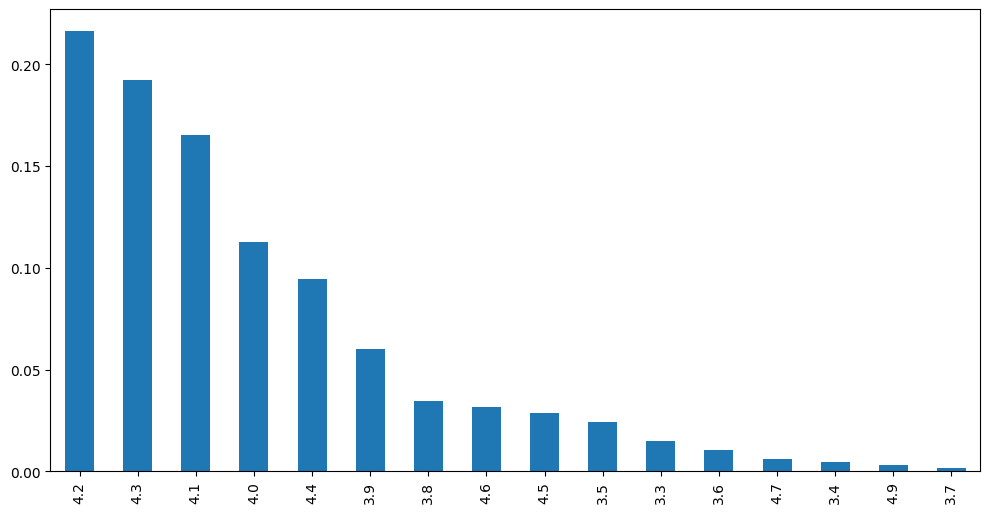

In [ ]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

**No of unique users and items**

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['product name'].nunique())

Number of unique USERS in Raw data =  666
Number of unique ITEMS in Raw data =  483


**Users with most no of rating**

In [ ]:
# Top 10 users based on rating
most_rated = df.groupby('user id').size().sort_values(ascending=False)[:10]
most_rated

user id
A106YUCY4SVX1D    1
A3E4YU6APQLRKE    1
A3EI9TX2A4MUSZ    1
A3F069UFW04K1E    1
A3F0Y83DVO5TIY    1
A3F6E9FYLZ7MXZ    1
A3F9NDKO3GFOCH    1
A3GCTN5ZPQT657    1
A3GF7FD6065R2H    1
A3GG0HR8199P8Z    1
dtype: int64

**Pre-Processing**

In [ ]:
counts = df['user id'].value_counts()
df_final = df[df['user id'].isin(counts[counts >= 1].index)]

In [ ]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['product name'].nunique())

The number of observations in the final data = 666
Number of unique USERS in the final data =  666
Number of unique PRODUCTS in the final data =  483


**Checking the density of the rating matrix**

In [ ]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user id', columns ='product name', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (666, 483)
given_num_of_ratings =  666
possible_num_of_ratings =  321678
density: 0.21%


product name,A10E,"APPLE iPhone 11 (Black, 128 GB)","APPLE iPhone 11 (Black, 64 GB)","APPLE iPhone 11 (Green, 64 GB)","APPLE iPhone 11 (Purple, 64 GB)","APPLE iPhone 11 (Red, 128 GB)","APPLE iPhone 11 (Red, 64 GB)","APPLE iPhone 11 (White, 128 GB)","APPLE iPhone 11 (White, 64 GB)","APPLE iPhone 12 (White, 128 GB)",...,"vivo V27 5G (Magic Blue, 128 GB)","vivo V27 5G (Noble Black, 256 GB)","vivo V27 Pro 5G (Magic Blue, 128 GB)","vivo V27 Pro 5G (Magic Blue, 256 GB)","vivo X21 (Black, 128 GB)","vivo X60 (Shimmer Blue, 128 GB)","vivo X70 Pro (Aurora Dawn, 128 GB)","vivo Y02 (Cosmic Grey, 32 GB)","vivo Y02t (Cosmic Grey, 64 GB)","vivo Y02t (Sunset Gold, 64 GB)"
user id,,,,,,,,,,,,,,,,,,,,,
A106YUCY4SVX1D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1079KKA0AXSL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A107S4MT25VXQ5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A108UXJTIV8XXY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A110S8IJ3ZID0D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Rank Based Recommendation System**

In [ ]:
#Calculate the average rating for each product
average_rating = df_final.groupby('product name').mean()['rating']

#Calculate the count of ratings for each product
count_rating = df_final.groupby('product name').count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
product name,,
"IQOO Neo 7 Pro (Dark Storm, 256 GB)",4.9,1
"SAMSUNG Galaxy F34 5G (Electric Black, 128 GB)",4.9,1
"APPLE iPhone 13 (Blue, 128 GB)",4.7,1
"APPLE iPhone 13 (Green, 128 GB)",4.7,1
"APPLE iPhone 13 (Pink, 128 GB)",4.7,2


In [ ]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

**Recommending top 5 products with 1 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 1))

['APPLE iPhone 13 (Pink, 128 GB)',
 'OnePlus Nord 3 5G (Tempest Gray, 128 GB)',
 'APPLE iPhone 11 (Black, 128 GB)',
 'OnePlus 11R 5G (Sonic Black, 256 GB)',
 'OnePlus 11R 5G (Sonic Black, 128 GB)']

**Recommending top 5 products with 3 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 3))

['OnePlus 11R 5G (Sonic Black, 128 GB)',
 'realme 11 Pro+ 5G (Sunrise Beige, 256 GB)',
 'realme 11 Pro+ 5G (Astral Black, 256 GB)',
 'OnePlus 10R 5G (Sierra Black, 256 GB)',
 'REDMI 12C (Mint Green, 128 GB)']